In [1]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
import numpy as np
import scipy as sp
import h5py
from scipy.interpolate import interp1d
from scipy.linalg import sqrtm, solve_sylvester, solve_lyapunov
from scipy.integrate import quad
import matplotlib.pyplot as plt
import sys
import pseudo
import os
import copy
import glob
import miscUtil
import ops
import warnings
%matplotlib inline
#%matplotlib notebook

os.environ['DATA'] = os.environ['DATA186']
physDataDir = os.environ['DATA'] + 'phys/'
specDataDir = os.environ['DATA'] + 'spec/'
covDataDir = os.environ['DATA'] + 'cov/'
libDir = os.environ['LINLIB']
figureFolder = 'MTSMFigures/'

# Resolvent analysis for modified mean profiles

I'll start with some simple verification to reproduce the results of 
Moarref et. al. JFM (2013); Model-based scaling of the streamwise energy density ...

I'll call this paper, MSTM (Moarref, Sharma, Tropp, McKeon).

## Fig. 3 of MSTM
### Principal velocity response mode
At $Re_\tau = 10,000$, for $c=10$, $\lambda^+_x = 700$, and $\lambda^+_z = 100$. 

In [302]:
N = 401; Re = 10000.; c = 10.;
LxPlus = 700.; LzPlus = 100.
Nx = 101; Nz = 16

Lx = LxPlus/Re; Lz = LzPlus/Re
a = 2.*np.pi/Lx; b = 2.*np.pi/Lz; omega = a*c;
I2 = np.identity(2*N,dtype=np.complex); I3 = np.identity(3*N, dtype=np.complex)

statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = I3)
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si = weightDict['W3SqrtInv']

#A, C, B = statInst.makeSystem()
A = statInst.dynamicsMat(a=a,b=b)
C = statInst.velVor2primitivesMat(a=a,b=b)
B = statInst.primitives2velVorMat(a=a,b=b)

R = (1.j*omega*I2 + A)
R = -np.linalg.solve(R, I2)
H = C @ R @ B
H = W3s @ H @ W3si

velResp,ampl,forcing = np.linalg.svd(H)

# The velResp modes are (Clenshaw-Curtis) weighted velocities 
# Convert it to unweigthed
primaryMode = W3si @ velResp[:,0]
primaryMode = primaryMode.reshape((3,1,1,N))

# Calcualte the field at t=0 in physical space
xArr = np.linspace(0., Lx, Nx).reshape((Nx,1,1))
zArr = np.linspace(-Lz/2., Lz/2., Nz).reshape((1,Nz,1))
y = pseudo.chebdif(N,1)[0]
y = y.reshape((1,1,N))

#uPhys = np.zeros((Nx,Nz,N))
#vPhys = np.zeros((Nx,Nz,N))
#wPhys = np.zeros((Nx,Nz,N))

#uPhys = 4.* np.cos(b*zArr) * np.real( primaryMode[0] * np.exp(1.j*a*xArr)   )
#vPhys = 4.* np.cos(b*zArr) * np.real( primaryMode[1] * np.exp(1.j*a*xArr)   )
#wPhys = -4.*np.sin(b*zArr) * np.imag( primaryMode[2] * np.exp(1.j*a*xArr)   )

uPhys = np.real( primaryMode[0] * np.exp(1.j*(a*xArr+b*zArr))   )
vPhys = np.real( primaryMode[1] * np.exp(1.j*(a*xArr+b*zArr))   )
wPhys = np.real( primaryMode[2] * np.exp(1.j*(a*xArr+b*zArr))   )



Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=401
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 89.7597901025655 628.3185307179587 10000.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


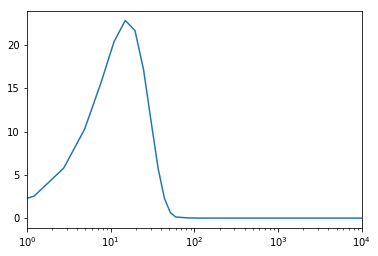

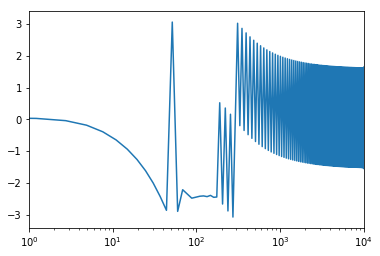

In [303]:
#plt.plot(Re*(1.-y[0,0]), np.abs(velResp[:N,0]))
#plt.plot(Re*(1.-y[0,0]), np.abs(velResp[N:2*N,0]))
#plt.plot(Re*(1.-y[0,0]), np.abs(velResp[2*N:3*N,0]))
plt.plot(Re*(1.-y[0,0]), np.abs(primaryMode[0,0,0]))
plt.xlim([1.,Re])
plt.xscale("log")
plt.show()

#plt.plot(Re*(1.-y[0,0]), np.angle(velResp[:N,0]))
#plt.plot(Re*(1.-y[0,0]), np.angle(velResp[N:2*N,0]))
#plt.plot(Re*(1.-y[0,0]), np.angle(velResp[2*N:3*N,0]))
plt.plot(Re*(1.-y[0,0]), np.angle(primaryMode[0,0,0]))
plt.xlim([1.,Re])
plt.xscale("log")
plt.show()


### So, the weight matrices are pretty messed up
Are they though?

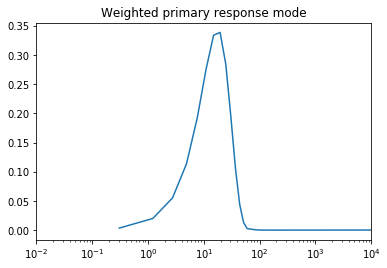

[  0.63671283   2.55428801   5.77617352  10.27538011  15.60043339]


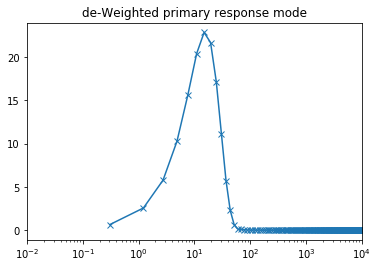

In [304]:
W3si = weightDict['W3SqrtInv']

plt.plot(Re*(1.- statInst.y), np.abs(velResp[:N,0]))
plt.xlim([0.01,Re])
plt.xscale('log')
plt.title("Weighted primary response mode")
plt.show()


plt.figure()
someMode = 1./np.sqrt(statInst.w) * velResp[:N,0]
someMode1 = (W3si @ velResp[:,0])[:N]
someMode = primaryMode[0,0,0]
print(np.abs(someMode[:5]))
plt.plot(Re*(1.- statInst.y), np.abs(someMode),'x-')
plt.xlim([0.01,Re])
plt.xscale('log')
plt.title("de-Weighted primary response mode")
plt.show()

## Fig. 3b of MTSM

(1-0j)


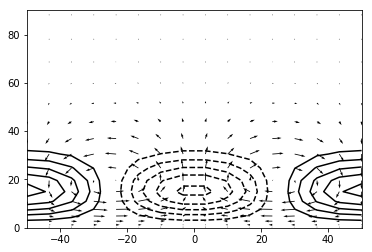

In [308]:
maxInd = np.argmax(np.abs(primaryMode[0,0,0,:N//2].flatten()))
phaseMaxInd = np.angle(primaryMode[0,0,0,maxInd])
primaryMode[:,0,0] = np.exp(-1.j*phaseMaxInd) * primaryMode[:,0,0]
print(np.exp(-1.j*phaseMaxInd))

uPhys = np.cos(b*zArr) * np.real( primaryMode[0] * np.exp(1.j*(a*xArr))   )
vPhys = np.cos(b*zArr) * np.real( primaryMode[1] * np.exp(1.j*(a*xArr))   )
wPhys =-np.sin(b*zArr) * np.imag( primaryMode[2] * np.exp(1.j*(a*xArr))   )

ny = statInst.N
Z,Y = np.meshgrid(Re*zArr.flatten(), Re*(1.-statInst.y))
#zArr1 
wPlane = wPhys[50,:,:ny]; vPlane = vPhys[50,:,:ny]
uPlane = uPhys[50,:,:ny]

levels = np.arange(-15,16,3); levels = np.delete(levels,5)
plt.contour(Z, Y, uPlane.T/np.sqrt(2),levels=levels, colors='k')
# Why the sqrt(2)? Because I define the energy norm with a 1/2 factor.
# In W3Sqrt, this shows up as a 1/sqrt(2) factor. 
# Doesn't matter. It's linear and can be scaled.
plt.ylim([0.,90.])
plt.yticks(np.arange(0., 81., 20.))
#plt.quiver(Z[::2,::2], Y[::2,::2], wPlane.T[::2,::2], -vPlane.T[::2,::2], units='y',scale=0.5)
plt.quiver(Z, Y, wPlane.T, -vPlane.T, units='y',scale=0.5)
# -v because I'm plotting 1-y 
plt.show()



In [312]:
if False:
    from mpl_toolkits.mplot3d import Axes3D
    uMax = np.max(uPhys)
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    X3D = xArr + np.zeros((Nx,Nz,N))
    Y3D = y + np.zeros((Nx,Nz,N))
    Z3D = zArr + np.zeros((Nx,Nz,N))

    # Need mayavi to use contour3d()
    # It's too much of a pain to install mayavi for python3
    # I'll ignore these plots for now.


## Fig. 4 of MTSM

Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 17.978885957543874 125.85220170280711 2003.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


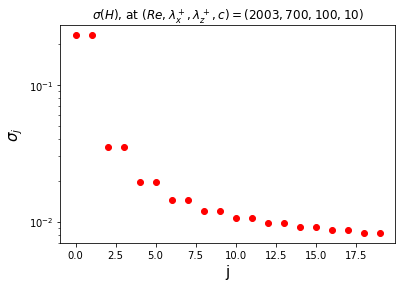

In [316]:
Re = 2003.; alfa = 25.4; kapa = 0.426; N = 251

# Fig 4.a in paper is for lx+ = 700, lz+ = 100, c = 10
# a = 2*pi/lx = 2*pi/(lx+ /ReTau) = ReTau * 2*pi/lx+
a = 2.*np.pi*Re/700.
b = 2.*np.pi*Re/100.
c = 10.; omega = a*c
I2 = np.identity(2*N, dtype=np.complex)
I3 = np.identity(3*N, dtype=np.complex)

statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = I3)
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si = weightDict['W3SqrtInv']

if False:
    A, C, B = statInst.makeSystem()
    I = np.identity(A.shape[0])
    R = (1.j*omega*I2 + A)
    R = -np.linalg.solve(R2, I)
    H = C @ R @ B
else:
    A = statInst.dynamicsMat(a=a,b=b)
    C = statInst.velVor2primitivesMat(a=a,b=b)
    B = statInst.primitives2velVorMat(a=a,b=b)

    R = (1.j*omega*I2 + A)
    R = -np.linalg.solve(R, I2)
    H = C @ R @ B
    H = W3s @ H @ W3si
    
U,S,V = np.linalg.svd(H)
plt.plot(np.arange(20),S[:20],'ro')

plt.yscale("log")
plt.xlabel("j",fontsize=15); plt.ylabel("$\\sigma_j$",fontsize=15)
plt.title("$\\sigma(H)$, at $(Re,\\lambda^+_x,\\lambda^+_z,c)=(2003,700,100,10)$")
plt.savefig(figureFolder+'svalsRe2003lx700lz100.pdf',format='pdf')
plt.show()

In [325]:
N = 251
meanDict = ops.turbMeanChannel(N=251,Re=2003.)
print(meanDict['U'][:27], 2003.*(1.-statInst.y[:27]))
print(meanDict['U'][50:60],(1.-statInst.y[50:60]))

Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
[  0.15564211   0.62246655   1.39990993   2.48345134   3.84483318
   5.38344828   6.9169732    8.2903547    9.45036078  10.41126526
  11.20842889  11.87694467  12.44565707  12.93681945  13.3672497
  13.74962002  14.09352432  14.40628465  14.69354085  14.95967748
  15.20813363  15.44162926  15.66233223  15.87198308  16.07198919
  16.26349667  16.44744585] [   0.15564816    0.62256845    1.40068831    2.4898868     3.88999464
    5.60079425    7.62201972    9.95335694   12.59444358   15.54486918
   18.80417519   22.37185507   26.24735435   30.43007072   34.91935411
   39.71450684   44.81478365   50.2193919    55.92749162   61.93819568
   68.25056994   74.86363336   81.77635816   88.98767001   96.49644816
  104.30152563  112.40168939]
[ 19.63624179  19.73867336  19.83955579  19.93894739  20.03690267
  20.13347252  20.22870446  20.32264277  20.41532872  20.50680065] [ 0.19540222  0.20286749  0.21045665  0.21816852  0.22600189  0.233955

In [335]:
ypTarget = 15.
yTarget0 = 15./2003.
yTarget = 1. - yTarget0
print(yTarget, pseudo.chebint(meanDict['U'], yTarget))

0.9925112331502746 [ 10.25413828]


In [336]:
N=251; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,61)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_state = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 10.25; omega = a*c   # U(y^+=15)
        
        A, C, B = statInst.makeSystem()
        I = np.identity(A.shape[0])
        R = (1.j*omega*I + A)
        R = -np.linalg.solve(R, I)
        H = C @ R @ B
        if False:
            A, C, B = statInst.makeSystem()
            I = np.identity(A.shape[0])
            R = (1.j*omega*I2 + A)
            R = -np.linalg.solve(R2, I)
            H = C @ R @ B
        else:
            A = statInst.dynamicsMat(a=a,b=b)
            C = statInst.velVor2primitivesMat(a=a,b=b)
            B = statInst.primitives2velVorMat(a=a,b=b)

            R = (1.j*omega*I2 + A)
            R = -np.linalg.solve(R, I2)
            H = C @ R @ B
            H = W3s @ H @ W3si

        
        
        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_state[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 666.804847975 2003.0
a, b, Re: 1258.52201703 666.804847975 20

In [330]:
N=251; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,61)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_yp100_state = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 16.17; omega = a*c
        # 16.17 is U(y^+=100) at Re=2003 for this U
        
        A, C, B = statInst.makeSystem()
        I = np.identity(A.shape[0])
        R = (1.j*omega*I + A)
        R = -np.linalg.solve(R, I)
        H = C @ R @ B
        if False:
            A, C, B = statInst.makeSystem()
            I = np.identity(A.shape[0])
            R = (1.j*omega*I2 + A)
            R = -np.linalg.solve(R2, I)
            H = C @ R @ B
        else:
            A = statInst.dynamicsMat(a=a,b=b)
            C = statInst.velVor2primitivesMat(a=a,b=b)
            B = statInst.primitives2velVorMat(a=a,b=b)

            R = (1.j*omega*I2 + A)
            R = -np.linalg.solve(R, I2)
            H = C @ R @ B
            H = W3s @ H @ W3si

        
        
        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_yp100_state[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 666.804847975 2003.0
a, b, Re: 1258.52201703 666.804847975 20

In [331]:
N=251; Re = 2003.
lxpArr = 10**np.linspace(1.,5.,61)
lzpArr = 10**np.linspace(1.,5.,30)
svals2norm_y02_state = np.zeros((lxpArr.size, lzpArr.size))

for ind0 in range(lxpArr.size):
    lxp = lxpArr[ind0]; lx = lxp/2003.; a = 2.*np.pi/lx
    for ind1 in range(lzpArr.size):
        lzp = lzpArr[ind1]; lz = lzp/2003.; b = 2.*np.pi/lz
        k2 = a**2 + b**2
        statInst = ops.statComp(a=a, b=b, N=N, Re=Re, covMat = np.identity(3*N))
        c = 19.7; omega = a*c
        # 16.17 is U(y=0.2) at Re=2003 for this U
        
        A, C, B = statInst.makeSystem()
        I = np.identity(A.shape[0])
        R = (1.j*omega*I + A)
        R = -np.linalg.solve(R, I)
        H = C @ R @ B
        if False:
            A, C, B = statInst.makeSystem()
            I = np.identity(A.shape[0])
            R = (1.j*omega*I2 + A)
            R = -np.linalg.solve(R2, I)
            H = C @ R @ B
        else:
            A = statInst.dynamicsMat(a=a,b=b)
            C = statInst.velVor2primitivesMat(a=a,b=b)
            B = statInst.primitives2velVorMat(a=a,b=b)

            R = (1.j*omega*I2 + A)
            R = -np.linalg.solve(R, I2)
            H = C @ R @ B
            H = W3s @ H @ W3si

        
        
        U,S,V = np.linalg.svd(H)
        s12_sq = S[0]**2 + S[1]**2
        sAll_sq = np.sum(S**2)
        svals2norm_y02_state[ind0,ind1] = s12_sq/sAll_sq


Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 1258.52201703 2003.0


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 1258.52201703 1258.52201703 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 916.072367358 2003.0
a, b, Re: 1258.52201703 916.072367358 2003.0
Using parameters Re=2003, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
a, b, Re: 1258.52201703 666.804847975 2003.0
a, b, Re: 1258.52201703 666.804847975 20

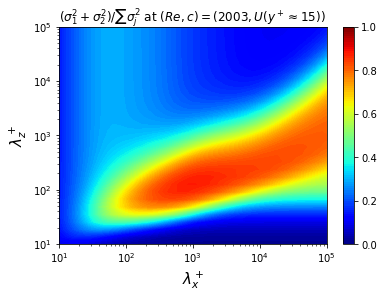

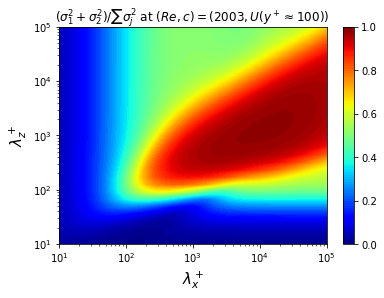

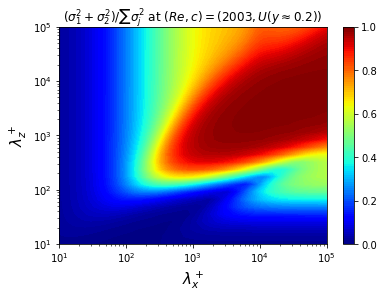

In [337]:
levels = np.linspace(0.,1.0,101)
cticks = np.linspace(0.,1.,6)

plt.contourf(lxpArr, lzpArr, svals2norm_state.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y^+\\approx 15))$")
plt.savefig(figureFolder+'svals12norm_yp15.pdf',format='pdf')
plt.show()

plt.contourf(lxpArr, lzpArr, svals2norm_yp100_state.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y^+\\approx 100))$")
plt.savefig(figureFolder+'svals12norm_yp100.pdf',format='pdf')
plt.show()

plt.contourf(lxpArr, lzpArr, svals2norm_y02_state.T, levels=levels,cmap="jet")
plt.xscale("log"); plt.yscale("log"); plt.colorbar(ticks=cticks)
plt.xlabel("$\\lambda_x^+$",fontsize=15)
plt.ylabel("$\\lambda_z^+$",fontsize=15)
plt.title(
    "$(\\sigma^2_1 + \\sigma^2_2)/\sum \\sigma^2_j$ at $(Re,c)=(2003,U(y\\approx 0.2))$")
plt.savefig(figureFolder+'svals12norm_y02.pdf',format='pdf')
plt.show()

# Mean velocity homogenization

I'm looking at two complementary problems.

1) Can the modification to the dynamics matrix from the covariance completion problem be modelled as being due to a change in mean velocity profile?

2) How do the resolvent modes change, considering their localization about critical layers, when the mean velocity profile is locally homogeneous (the staircase profile of UMZs)?

These lead to further questions such as finding similarity laws for this mean flow modification, and expressing eddy viscosity as a mean flow modification. Here, I look into the second problem. 

I need to create ''good'' mean velocity profiles. I've thought of two ways to do this. 

1) Introduce a local sine-like spike in the eddy viscosity. Since the mean velocity profile is computed as $\int\limits_0^y \frac{1-Y}{1+\nu_T(Y)}dY$, a very high value of $\nu_T$ produces a near-constant mean velocity, while a very low value produces a steep increase in the mean velocity. 

2) Assign a near-constant velocity to a few neighbouring wall-normal nodes. Since I use pseudo-spectral, I can obtain an exact set of Chebyshev polynomials that produce that particular profile. I can set the last several polynomials to zero, so that the velocity profile is smooth, but still retains some homogenization. As long as I drop a sufficient number of Cheb polynomials, the first and second derivatives should also be smooth enough. 

I'll start with the second method for now. 

There's also the question of bulk velocity: Should I ensure constant bulk velocity during the homogenization? The hierarchies of MTSM might be important to answering this question. 

Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.


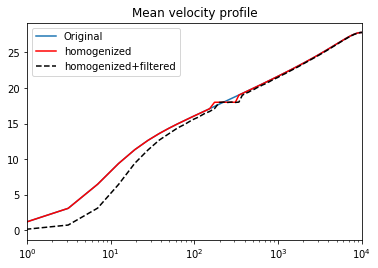

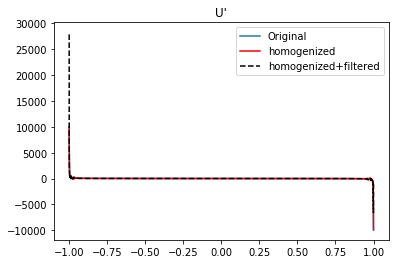

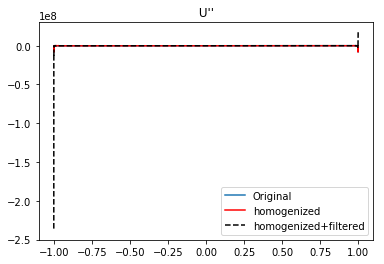

In [427]:
Re = 10000.; N=251; a= 2.5; b=7.; c = 18.
nInd =3; # Set values at 'nInd' nodes on either side to c
I2 = np.identity(2*N,dtype=np.complex); I3 = np.identity(3*N, dtype=np.complex)
statInst = ops.statComp(N=N,Re=Re,a=a,b=b, covMat = I3)

U0 = statInst.U[:-(N//2)].copy()
ind_Uc = np.where(U0<c)[0][-1]     # Suppose U0=c between U0[ind_Uc] and U0[ind_Uc+1]
U0[ind_Uc-nInd+1: ind_Uc+nInd+1] = c     # 'nInd' nodes on either side set to c
U0 = np.concatenate( (U0, U0[:N//2][::-1] ))
#U0 = pseudo.chebFilter(U0,Ndrop=0, symms='even')


U1 = pseudo.chebFilter(U0, Ndrop=5)

plt.plot(Re*(1.-statInst.y), statInst.U)
plt.plot(Re*(1.-statInst.y), U0, 'r-')
plt.plot(Re*(1.-statInst.y), U1, 'k--')
plt.xscale("log")
plt.xlim([1.,Re])
plt.title("Mean velocity profile")
plt.legend(['Original','homogenized','homogenized+filtered'])
plt.show()

D1 = statInst.D1
plt.plot(statInst.y, D1@statInst.U)
plt.plot(statInst.y, D1@U0, 'r-')
plt.plot(statInst.y, D1@U1, 'k--')
plt.title("U'")
plt.legend(['Original','homogenized','homogenized+filtered'])
plt.show()

D2 = statInst.D2
plt.plot(statInst.y, D2@statInst.U)
plt.plot(statInst.y, D2@U0, 'r-')
plt.plot(statInst.y, D2@U1, 'k--')
plt.title(" U'' ")
plt.legend(['Original','homogenized','homogenized+filtered'])
plt.show()



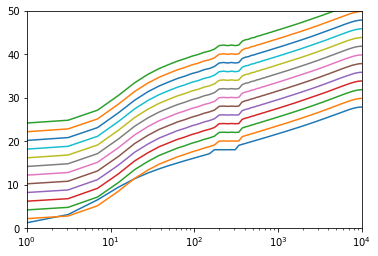

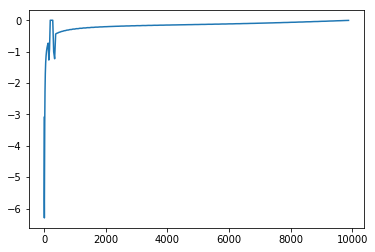

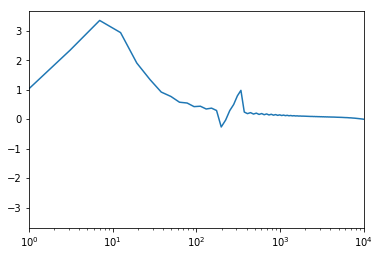

In [421]:
warnings.simplefilter('ignore')
yp = Re*(1.-statInst.y)

plt.figure()
plt.xscale("log"); plt.xlim([1.,Re])
plt.plot(yp, U0, label='homogenized')
for n in range(2,25,2):
    plt.plot(yp, np.abs(n+pseudo.chebFilter(U0, Ndrop=n)),label='Ndrop=%d'%n)
plt.ylim([0.,50.])
#plt.legend(loc=4)
plt.show()


U20 = pseudo.chebFilter(U0, Ndrop=10,symms='even')
plt.plot(yp[:N//2], U20[:N//2] - U20[-(N//2):][::-1])
plt.show()

plt.plot(yp, statInst.U - pseudo.chebFilter(U0, Ndrop=5) )
plt.xlim([1.,Re])
plt.xscale("log")
plt.show()

This way of homogenizing isn't going so well. Let's try the eddy viscosity based one. 

In [500]:
alfa = 25.4
kapa = 0.426
Re = statInst.Re; N = statInst.N; y = 1.-statInst.y
yPlusEq = 500.; 
zoneSize = 50.   # Extent of sine-wave-window
#spikeSize = 1000. # Amplitude of sine wave to introduce to nu_E
print("Using parameters Re=%.4g, alfa=%.4g, kapa=%.4g, N=%d"%(Re,alfa,kapa,N))
# The basic eddy viscosity equation
nuEbase = lambda zt: -0.5 + 0.5*np.sqrt( 1.+
            (kapa*Re/3.* (2.*zt - zt**2) * (3. - 4.*zt + 2.*zt**2) *
                         (1. - np.exp( (np.abs(zt-1.)-1.)*Re/alfa )   )    )**2)

# Choose location around which to homogenize in yPlus units
# I'll start calling this "equalization" instead of "homogenization"
assert yPlusEq < Re
yp = Re*y
eqInd = np.where(yp < yPlusEq)[0][-1] # yPlusEq is between yp[eqInd] and the next
print(eqInd)


def Utmp(zoneSize,spikeSize):
    
    # If the eddy viscosity profile needed for integration is for yp<yp_Eq,
    #    use the basic equation. Otherwise, use the enhanced equation
    def nuE(xi0):
        if isinstance(xi0,np.ndarray): print('xi0 is a numpy array')
        xi = np.array(xi0).flatten()
        if isinstance(xi,np.ndarray): print('xi is a numpy array')
        indDiff = xi.size - (eqInd - zoneSize)
        if indDiff < 0 : return nuEbase(xi)
        elif indDiff <= sineWave.size : 
            nuEenhanced = nuEbase(xi)  
            nuEenhanced[-indDiff:] += sineWave[:indDiff]
        else:
            nuEenhanced = nuEbase(xi)
            nuEenhanced[eqInd-zoneSize:eqInd+zoneSize+1] += sineWave
        return nuEenhanced
    

    intFun = lambda xi: Re * (1.-xi)/(1. + nuE(xi))
    U = np.zeros(statInst.N)

    for ind in range(np.int(np.ceil(N/2))):
        U[ind] = quad( intFun, 0., y[ind])[0]
    U[-(N//2):] = U[:N//2][::-1] 
    
    return U

U1 = Utmp(20,10.)
U2 = Utmp(10,1000.)

Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=251
24
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
xi is a numpy array
x

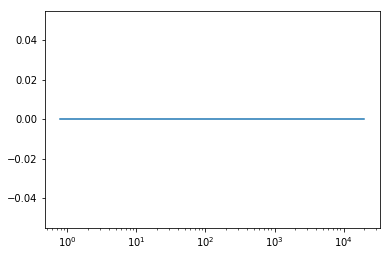

In [501]:
plt.plot(yp, U10_10 - U10_100)
plt.xscale("log")

In [484]:
Re = 2003.; alfa = 25.4; kapa=0.426; N=251
y = 1.- pseudo.chebdif(N,1)[0]
yp = Re*y
eqInd = 24; zoneSize = 4; spikeSize = 50.
sineWave = -spikeSize * np.sin(np.arange(-zoneSize,zoneSize+1)*np.pi/zoneSize)
# The basic eddy viscosity equation
nuEbase = lambda zt: -0.5 + 0.5*np.sqrt( 1.+
            (kapa*Re/3.* (2.*zt - zt**2) * (3. - 4.*zt + 2.*zt**2) *
                         (1. - np.exp( (np.abs(zt-1.)-1.)*Re/alfa )   )    )**2)

def nuE(xi0):
    print(xi0.size)
    xi = np.array(xi0).flatten()
    print(xi.size)
    indDiff = xi.size - (eqInd - zoneSize)
    if indDiff < 0 : return nuEbase(xi)
    elif indDiff <= sineWave.size : 
        nuEenhanced = nuEbase(xi)  
        nuEenhanced[-indDiff:] += sineWave[:indDiff]
    else:
        nuEenhanced = nuEbase(xi)
        nuEenhanced[eqInd-zoneSize:eqInd+zoneSize+1] += sineWave
    return nuEenhanced



50
50


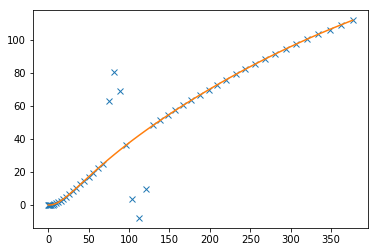

In [486]:
plt.plot(yp[:50], nuE(y[:50]),'x')
plt.plot(yp[:50], nuEbase(y[:50]))
#plt.xscale("log")


In [3]:
Re = 10000.; N=251; a= 2.5; b=7.
I2 = np.identity(2*N,dtype=np.complex); I3 = np.identity(3*N, dtype=np.complex)
statInst = ops.statComp(N=N,Re=Re,a=a,b=b, covMat = I3)


alfa = 25.4
kapa = 0.426
Re = statInst.Re; N = statInst.N; y = 1.-statInst.y; yp = Re*y
negFactor0 = -1.
posFactor0 = 40.
def nuDiffSine(yScal, ypMin, ypMax, sineAmp,
              negFactor=negFactor0, posFactor=posFactor0,
              switchLoc=0.5):
    ypScal = Re*yScal
    if ypMin <= ypScal <= ypMin+switchLoc*(ypMax-ypMin):
        sineCoord = ypScal - ypMin
        sineSize = ypMax - ypMin
        nuAdd = negFactor* sineAmp* np.sin( (sineCoord/sineSize - 0.5)*2.*np.pi )
        #nuAdd = 0.1* (ypScal**0.5) * nuAdd
    elif ypMin+switchLoc*(ypMax-ypMin)< ypScal < ypMax:
        sineCoord = ypScal - ypMin
        sineSize = ypMax - ypMin
        nuAdd = posFactor* sineAmp* np.sin( (sineCoord/sineSize - 0.5)*2.*np.pi )
        #nuAdd = 0.1* (ypScal**0.5) * nuAdd
    else: nuAdd = 0.
    return nuAdd

def nuDiffHat(yScal, ypMin, ypMax, hatAmp,
              negFactor=negFactor0, posFactor=posFactor0,
              switchLoc=0.5):
    ypScal = Re*yScal
    if ypMin <= ypScal <= ypMin+switchLoc*(ypMax-ypMin):
        nuAdd = negFactor* hatAmp
    elif ypMin+switchLoc*(ypMax-ypMin)< ypScal < ypMax:
        nuAdd =  posFactor* hatAmp
    else: nuAdd = 0.
    return nuAdd


print("Using parameters Re=%.4g, alfa=%.4g, kapa=%.4g, N=%d"%(Re,alfa,kapa,N))
# The basic eddy viscosity equation
nuEbase = lambda zt: -0.5 + 0.5*np.sqrt( 1.+
            (kapa*Re/3.* (2.*zt - zt**2) * (3. - 4.*zt + 2.*zt**2) *
                         (1. - np.exp( (np.abs(zt-1.)-1.)*Re/alfa )   )    )**2)

def Utmp(ypMin,ypMax, sineAmp,**kwargs):
    nuDiffLoc = lambda xi: nuDiffHat(xi, ypMin,ypMax,sineAmp,**kwargs)
    nuE = lambda xi: nuEbase(xi) + nuDiffLoc(xi)

    intFun = lambda xi: Re * (1.-xi)/(1. + nuE(xi))
    U = np.zeros(statInst.N)

    for ind in range(np.int(np.ceil(N/2))):
        U[ind] = quad( intFun, 0., y[ind])[0]
    U[-(N//2):] = U[:N//2][::-1] 
    
    return U



Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=251


/home/svadarevu/linenv/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)


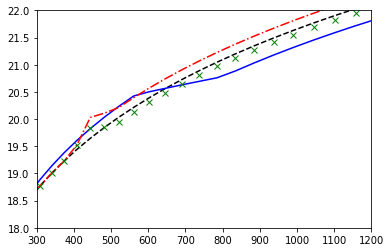

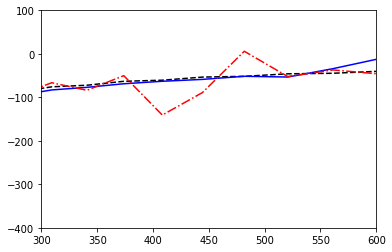

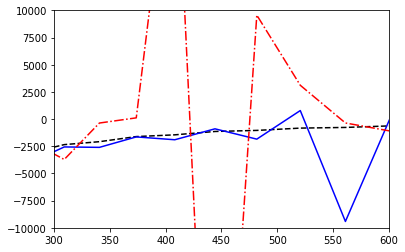

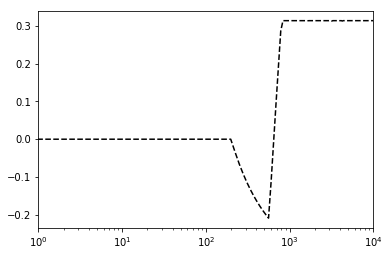

In [36]:
U0 = Utmp(400., 600., 0.)
U1 = Utmp(200., 800., 10., switchLoc=0.61)
U2 = Utmp(400., 500., 10.)
U3 = Utmp(400., 500., 10., switchLoc=0.3)


plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, U0,'k--')
plt.plot(yp, U1,'b')
plt.plot(yp, U2,'r-.')
plt.plot(yp, U3,'gx')
plt.xlim([300.,1200.])
plt.ylim([18.,22.])
#plt.xscale("log")
plt.show()


DM = pseudo.chebdif(U0.size,2)[1]
D1 = DM[:,:,0]
D2 = DM[:,:,1]

plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, D1@U0,'k--')
plt.plot(yp, D1@U1,'b')
plt.plot(yp, D1@U2,'r-.')
plt.xlim([300.,600.])
#plt.autoscale()
plt.xlim([300.,600.])
plt.ylim([-400.,100.])
#plt.xscale("log")
plt.show()


plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, D2@U0,'k--')
plt.plot(yp, D2@U1,'b')
plt.plot(yp, D2@U2,'r-.')
plt.xlim([300.,600.])
plt.ylim([-1.e04,1.e04])
#plt.xscale("log")
plt.show()

plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, U0-U1,'k--')
plt.xscale("log")
plt.show()



# Response to stochastic forcing for a homogenized profile

## Base flow without homogenization, and homogenization scheme

In [163]:
Re = 10000.; N=251; a= 2.5; b=7.
I2 = np.identity(2*N,dtype=np.complex); I3 = np.identity(3*N, dtype=np.complex)
statInst = ops.statComp(N=N,Re=Re,a=a,b=b, covMat = I3)


alfa = 25.4
kapa = 0.426
Re = statInst.Re; N = statInst.N; y = 1.-statInst.y; yp = Re*y
negFactor0 = -1.
posFactor0 = 40.
def nuDiffSine(yScal, ypMin, ypMax, sineAmp,
              negFactor=negFactor0, posFactor=posFactor0,
              switchLoc=0.5):
    ypScal = Re*yScal
    if ypMin <= ypScal <= ypMin+switchLoc*(ypMax-ypMin):
        sineCoord = ypScal - ypMin
        sineSize = ypMax - ypMin
        nuAdd = negFactor* sineAmp* np.sin( (sineCoord/sineSize - 0.5)*2.*np.pi )
        #nuAdd = 0.1* (ypScal**0.5) * nuAdd
    elif ypMin+switchLoc*(ypMax-ypMin)< ypScal < ypMax:
        sineCoord = ypScal - ypMin
        sineSize = ypMax - ypMin
        nuAdd = posFactor* sineAmp* np.sin( (sineCoord/sineSize - 0.5)*2.*np.pi )
        #nuAdd = 0.1* (ypScal**0.5) * nuAdd
    else: nuAdd = 0.
    return nuAdd

def nuDiffHat(yScal, ypMin, ypMax, hatAmp,
              negFactor=negFactor0, posFactor=posFactor0,
              switchLoc=0.5):
    ypScal = Re*yScal
    if ypMin <= ypScal <= ypMin+switchLoc*(ypMax-ypMin):
        nuAdd = negFactor* hatAmp
    elif ypMin+switchLoc*(ypMax-ypMin)< ypScal < ypMax:
        nuAdd =  posFactor* hatAmp
    else: nuAdd = 0.
    return nuAdd


print("Using parameters Re=%.4g, alfa=%.4g, kapa=%.4g, N=%d"%(Re,alfa,kapa,N))
# The basic eddy viscosity equation
nuEbase = lambda zt: -0.5 + 0.5*np.sqrt( 1.+
            (kapa*Re/3.* (2.*zt - zt**2) * (3. - 4.*zt + 2.*zt**2) *
                         (1. - np.exp( (np.abs(zt-1.)-1.)*Re/alfa )   )    )**2)

def Utmp(ypMin,ypMax, sineAmp,**kwargs):
    nuDiffLoc = lambda xi: nuDiffHat(xi, ypMin,ypMax,sineAmp,**kwargs)
    nuE = lambda xi: nuEbase(xi) + nuDiffLoc(xi)

    intFun = lambda xi: Re * (1.-xi)/(1. + nuE(xi))
    U = np.zeros(statInst.N)

    for ind in range(np.int(np.ceil(N/2))):
        U[ind] = quad( intFun, 0., y[ind])[0]
    U[-(N//2):] = U[:N//2][::-1] 
    
    return U



Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=251
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=251


## Case 1
### Homogenization in the early log layer

/home/svadarevu/linenv/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy vis

a, b, Re: 2.5 7.0 10000.0
a, b, Re: 2.5 7.0 10000.0
a, b, Re: 2.5 7.0 10000.0


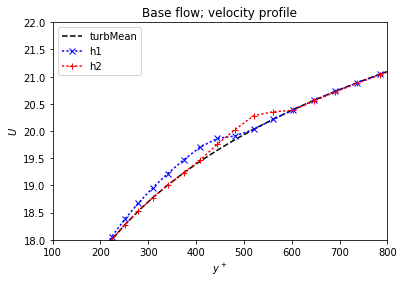

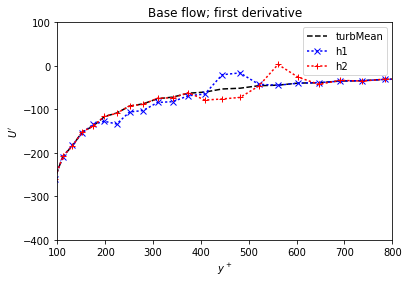

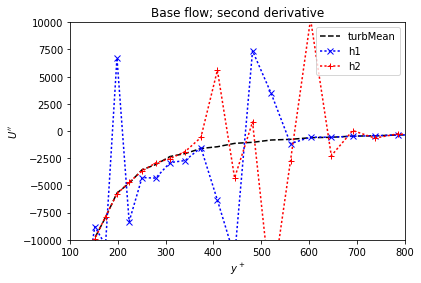

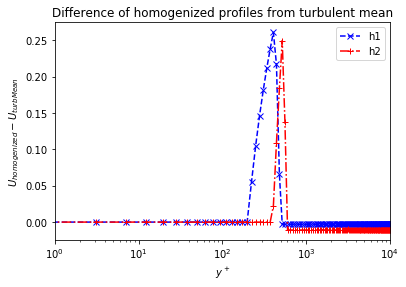

In [151]:
statInst1 = copy.deepcopy(statInst)
statInst2 = copy.deepcopy(statInst)
U1 = Utmp(200., 500., 15., switchLoc=0.77)
U2 = Utmp(400., 600., 50., switchLoc=0.65)

statInst1.U = U1
statInst1.dU = D1 @ U1
statInst1.d2U = D2 @ U1

statInst2.U = U2
statInst2.dU = D1 @ U2
statInst2.d2U = D2 @ U2


A,C,B = statInst.makeSystemNew()
A1,C1,B1 = statInst1.makeSystemNew()
A2,C2,B2 = statInst2.makeSystemNew()

U0 = statInst.U; U1 = statInst1.U; U2 = statInst2.U
plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, U0,'k--')
plt.plot(yp, U1,'bx:')
plt.plot(yp, U2,'r+:')
plt.xlim([100.,800.])
plt.ylim([18.,22.])
plt.title("Base flow; velocity profile")
plt.xlabel('$y^+$')
plt.ylabel('$U$')
plt.legend(['turbMean','h1', 'h2'])
#plt.xscale("log")
plt.show()

dU0 = statInst.dU; dU1 = statInst1.dU; dU2 = statInst2.dU
plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, dU0,'k--')
plt.plot(yp, dU1,'bx:')
plt.plot(yp, dU2,'r+:')
#plt.autoscale()
plt.xlim([100.,800.])
plt.ylim([-400.,100.])
#plt.xscale("log")
plt.title("Base flow; first derivative")
plt.xlabel('$y^+$')
plt.ylabel("$U'$")
plt.legend(['turbMean','h1', 'h2'])
plt.show()

d2U0 = statInst.d2U; d2U1 = statInst1.d2U; d2U2 = statInst2.d2U
plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, d2U0,'k--')
plt.plot(yp, d2U1,'bx:')
plt.plot(yp, d2U2,'r+:')
plt.xlim([100.,800.])
plt.ylim([-1.e04,1.e04])
plt.title("Base flow; second derivative")
plt.xlabel('$y^+$')
plt.ylabel("$U''$")
#plt.xscale("log")
plt.legend(['turbMean','h1', 'h2'])
plt.show()

plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, U1-U0,'bx--')
plt.plot(yp, U2-U0,'r+-.')
plt.xscale("log")
plt.ylabel("$U_{homogenized}-U_{turbMean}$")
plt.xlabel("$y^+$")
plt.legend(['h1','h2'])
plt.title("Difference of homogenized profiles from turbulent mean")
plt.show()


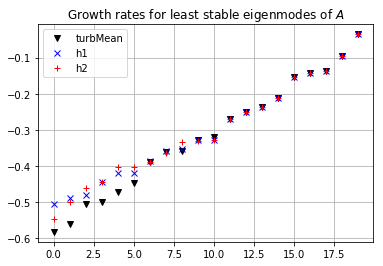

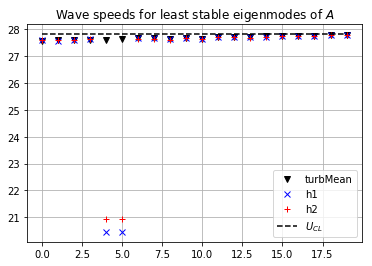

In [155]:
evals = np.linalg.eigvals(A);  sortInd = np.argsort(evals.real)
evalsRe = evals[sortInd].real; evalsIm = evals[sortInd].imag

evals1 = np.linalg.eigvals(A1);  sortInd1 = np.argsort(evals1.real)
evals1Re = evals1[sortInd1].real; evals1Im = evals1[sortInd1].imag

evals2 = np.linalg.eigvals(A2);  sortInd2 = np.argsort(evals2.real)
evals2Re = evals2[sortInd2].real; evals2Im = evals2[sortInd2].imag

plt.plot(evalsRe[-20:],'kv')
plt.plot(evals1Re[-20:],'bx')
plt.plot(evals2Re[-20:],'r+')
#plt.ylim([-1.,0.])
plt.grid('on')
plt.title("Growth rates for least stable eigenmodes of $A$")
plt.legend(['turbMean','h1', 'h2'], loc=2)
plt.show()

plt.plot(-evalsIm[-20:]/a,'kv')
plt.plot(-evals1Im[-20:]/a,'bx')
plt.plot(-evals2Im[-20:]/a,'r+')
plt.plot(np.max(U0)*np.ones(20),'k--')
#plt.ylim([-1.,0.])
plt.grid('on')
plt.title("Wave speeds for least stable eigenmodes of $A$")
plt.legend(['turbMean','h1', 'h2', '$U_{CL}$'], loc=4)
plt.show()




In [156]:
X = solve_lyapunov(A, -1.e-5*I2)
X1= solve_lyapunov(A1,-1.e-5*I2)
X2= solve_lyapunov(A2,-1.e-5*I2)
Phi = C @ X @ C.conj().T
Phi1= C1@ X1@ C1.conj().T
Phi2= C2@ X2@ C2.conj().T
N = statInst.N
yp = statInst.Re*(1.-statInst.y)

weightDict = pseudo.weightMats(N=N)
W3si = weightDict['W3SqrtInv']
Phi = W3si @ Phi  @ W3si
Phi1= W3si @ Phi1 @ W3si
Phi2= W3si @ Phi2 @ W3si


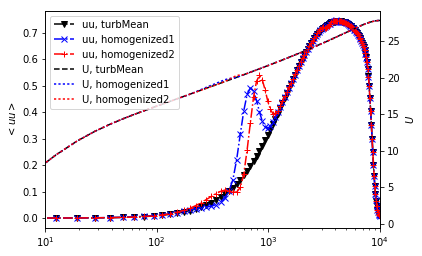

In [157]:
fig,ax1 = plt.subplots()

ax1.plot(yp,  np.real(np.diag( Phi[:N,:N])), 'kv-.',label='uu, turbMean')
ax1.plot(yp,  np.real(np.diag(Phi1[:N,:N])), 'bx-.',label='uu, homogenized1')
ax1.plot(yp,  np.real(np.diag(Phi2[:N,:N])), 'r+-.',label='uu, homogenized2')
ax1.set_xlim([100.,10000.])
ax1.set_xscale("log")
ax1.set_ylabel("$<uu>$")
ax1.set_xlim([10.,Re])

ax2 = ax1.twinx()
ax2.plot(yp, U0, 'k--',label='U, turbMean')
ax2.plot(yp, U1, 'b:',label='U, homogenized1')
ax2.plot(yp, U2, 'r:',label='U, homogenized2')
ax2.set_ylabel("$U$")
ax2.set_xlim([10.,Re])
plt.legend()
plt.title("")
plt.xlabel("$y^+$")

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=2)

plt.title("Base flow and streamwise kinetic energy")

plt.show()

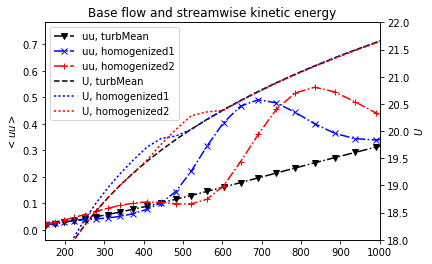

In [159]:
fig,ax1 = plt.subplots()

ax1.plot(yp,  np.real(np.diag( Phi[:N,:N])), 'kv-.',label='uu, turbMean')
ax1.plot(yp,  np.real(np.diag(Phi1[:N,:N])), 'bx-.',label='uu, homogenized1')
ax1.plot(yp,  np.real(np.diag(Phi2[:N,:N])), 'r+-.',label='uu, homogenized2')
ax1.set_xlim([150.,1000.])
#ax1.set_xscale("log")
ax1.set_ylabel("$<uu>$")
ax1.set_xlim([10.,Re])


ax2 = ax1.twinx()
ax2.plot(yp, U0, 'k--',label='U, turbMean')
ax2.plot(yp, U1, 'b:',label='U, homogenized1')
ax2.plot(yp, U2, 'r:',label='U, homogenized2')
ax2.set_ylabel("$U$")
ax2.set_xlim([150.,1000.])
ax2.set_ylim([18.,22.])
plt.legend()
plt.title("")
plt.xlabel("$y^+$")

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=2)

plt.title("Base flow and streamwise kinetic energy")

plt.show()

## Case 2
### Homogenization in the buffer layer

/home/svadarevu/linenv/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  warnings.warn(msg, IntegrationWarning)
/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy vis

a, b, Re: 2.5 7.0 10000.0
a, b, Re: 2.5 7.0 10000.0
a, b, Re: 2.5 7.0 10000.0


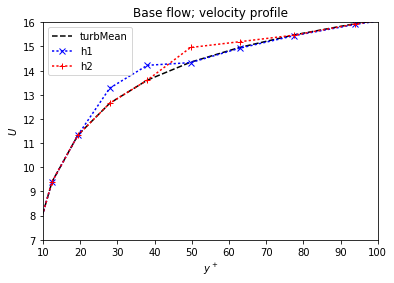

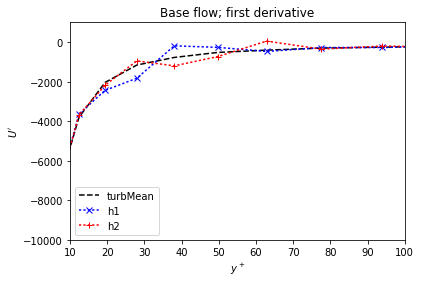

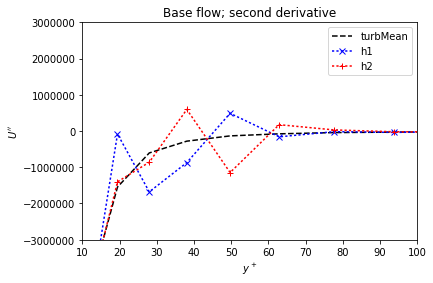

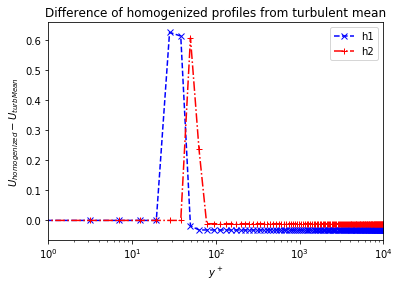

In [178]:
statInst1 = copy.deepcopy(statInst)
statInst2 = copy.deepcopy(statInst)
U1 = Utmp(20., 50., 2.2, switchLoc=0.5)
U2 = Utmp(40., 70., 8., switchLoc=0.4)

statInst1.U = U1
statInst1.dU = D1 @ U1
statInst1.d2U = D2 @ U1

statInst2.U = U2
statInst2.dU = D1 @ U2
statInst2.d2U = D2 @ U2


A,C,B = statInst.makeSystemNew()
A1,C1,B1 = statInst1.makeSystemNew()
A2,C2,B2 = statInst2.makeSystemNew()

U0 = statInst.U; U1 = statInst1.U; U2 = statInst2.U
plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, U0,'k--')
plt.plot(yp, U1,'bx:')
plt.plot(yp, U2,'r+:')
plt.xlim([10.,100.])
plt.ylim([7.,16.])
plt.title("Base flow; velocity profile")
plt.xlabel('$y^+$')
plt.ylabel('$U$')
plt.legend(['turbMean','h1', 'h2'])
#plt.xscale("log")
plt.show()

dU0 = statInst.dU; dU1 = statInst1.dU; dU2 = statInst2.dU
plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, dU0,'k--')
plt.plot(yp, dU1,'bx:')
plt.plot(yp, dU2,'r+:')
#plt.autoscale()
plt.xlim([10.,100.])
plt.ylim([-10000.,1000.])
#plt.xscale("log")
plt.title("Base flow; first derivative")
plt.xlabel('$y^+$')
plt.ylabel("$U'$")
plt.legend(['turbMean','h1', 'h2'])
plt.show()

d2U0 = statInst.d2U; d2U1 = statInst1.d2U; d2U2 = statInst2.d2U
plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, d2U0,'k--')
plt.plot(yp, d2U1,'bx:')
plt.plot(yp, d2U2,'r+:')
plt.xlim([10.,100.])
plt.ylim([-3.e06,3.e06])
plt.title("Base flow; second derivative")
plt.xlabel('$y^+$')
plt.ylabel("$U''$")
#plt.xscale("log")
plt.legend(['turbMean','h1', 'h2'])
plt.show()

plt.figure()
plt.xlim([1.,Re])
plt.plot(yp, U1-U0,'bx--')
plt.plot(yp, U2-U0,'r+-.')
plt.xscale("log")
plt.ylabel("$U_{homogenized}-U_{turbMean}$")
plt.xlabel("$y^+$")
plt.legend(['h1','h2'])
plt.title("Difference of homogenized profiles from turbulent mean")
plt.show()


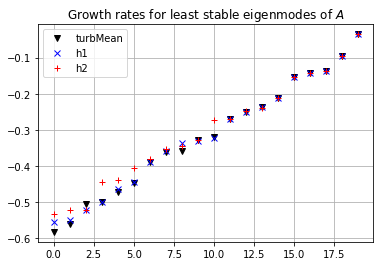

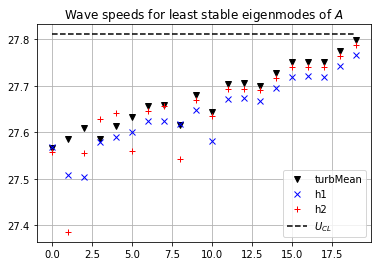

In [179]:
evals = np.linalg.eigvals(A);  sortInd = np.argsort(evals.real)
evalsRe = evals[sortInd].real; evalsIm = evals[sortInd].imag

evals1 = np.linalg.eigvals(A1);  sortInd1 = np.argsort(evals1.real)
evals1Re = evals1[sortInd1].real; evals1Im = evals1[sortInd1].imag

evals2 = np.linalg.eigvals(A2);  sortInd2 = np.argsort(evals2.real)
evals2Re = evals2[sortInd2].real; evals2Im = evals2[sortInd2].imag

plt.plot(evalsRe[-20:],'kv')
plt.plot(evals1Re[-20:],'bx')
plt.plot(evals2Re[-20:],'r+')
#plt.ylim([-1.,0.])
plt.grid('on')
plt.title("Growth rates for least stable eigenmodes of $A$")
plt.legend(['turbMean','h1', 'h2'], loc=2)
plt.show()

plt.plot(-evalsIm[-20:]/a,'kv')
plt.plot(-evals1Im[-20:]/a,'bx')
plt.plot(-evals2Im[-20:]/a,'r+')
plt.plot(np.max(U0)*np.ones(20),'k--')
#plt.ylim([-1.,0.])
plt.grid('on')
plt.title("Wave speeds for least stable eigenmodes of $A$")
plt.legend(['turbMean','h1', 'h2', '$U_{CL}$'], loc=4)
plt.show()




In [180]:
X = solve_lyapunov(A, -1.e-5*I2)
X1= solve_lyapunov(A1,-1.e-5*I2)
X2= solve_lyapunov(A2,-1.e-5*I2)
Phi = C @ X @ C.conj().T
Phi1= C1@ X1@ C1.conj().T
Phi2= C2@ X2@ C2.conj().T
N = statInst.N
yp = statInst.Re*(1.-statInst.y)

weightDict = pseudo.weightMats(N=N)
W3si = weightDict['W3SqrtInv']
Phi = W3si @ Phi  @ W3si
Phi1= W3si @ Phi1 @ W3si
Phi2= W3si @ Phi2 @ W3si


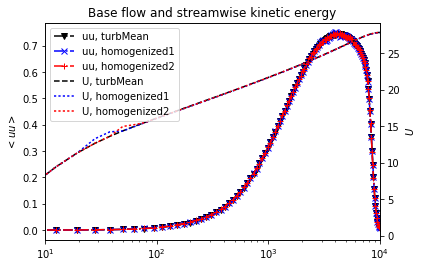

In [181]:
fig,ax1 = plt.subplots()

ax1.plot(yp,  np.real(np.diag( Phi[:N,:N])), 'kv-.',label='uu, turbMean')
ax1.plot(yp,  np.real(np.diag(Phi1[:N,:N])), 'bx-.',label='uu, homogenized1')
ax1.plot(yp,  np.real(np.diag(Phi2[:N,:N])), 'r+-.',label='uu, homogenized2')
ax1.set_xlim([100.,10000.])
ax1.set_xscale("log")
ax1.set_ylabel("$<uu>$")
ax1.set_xlim([10.,Re])

ax2 = ax1.twinx()
ax2.plot(yp, U0, 'k--',label='U, turbMean')
ax2.plot(yp, U1, 'b:',label='U, homogenized1')
ax2.plot(yp, U2, 'r:',label='U, homogenized2')
ax2.set_ylabel("$U$")
ax2.set_xlim([10.,Re])
plt.legend()
plt.title("")
plt.xlabel("$y^+$")

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=2)

plt.title("Base flow and streamwise kinetic energy")

plt.show()

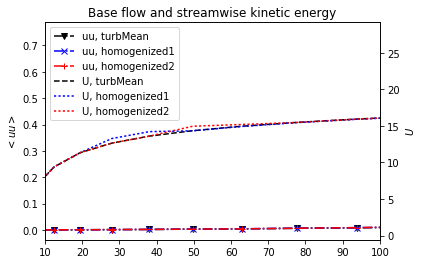

In [184]:
fig,ax1 = plt.subplots()

ax1.plot(yp,  np.real(np.diag( Phi[:N,:N])), 'kv-.',label='uu, turbMean')
ax1.plot(yp,  np.real(np.diag(Phi1[:N,:N])), 'bx-.',label='uu, homogenized1')
ax1.plot(yp,  np.real(np.diag(Phi2[:N,:N])), 'r+-.',label='uu, homogenized2')
ax1.set_xlim([10.,100.])
#ax1.set_xscale("log")
ax1.set_ylabel("$<uu>$")


ax2 = ax1.twinx()
ax2.plot(yp, U0, 'k--',label='U, turbMean')
ax2.plot(yp, U1, 'b:',label='U, homogenized1')
ax2.plot(yp, U2, 'r:',label='U, homogenized2')
ax2.set_ylabel("$U$")
ax2.set_xlim([10.,100.])
#ax2.set_ylim([18.,22.])
plt.legend()
plt.title("")
plt.xlabel("$y^+$")

line1,label1 = ax1.get_legend_handles_labels()
line2,label2 = ax2.get_legend_handles_labels()
ax2.legend(line1+line2, label1+label2,loc=2)

plt.title("Base flow and streamwise kinetic energy")

plt.show()

# Constraining homogenized velocity profiles

I'm pursuing two constraints. 

1) ** Ensure that the velocity profile isn't affected at some reference location that is sufficiently far from the region of homogenization. I'll use the geometric mean of the end of homogenization and the edge of the log layer as this reference location.**

2) ** Drive the least stable eigenmode towards marginal stability. **

For the first constraint, I'll use 'switchLoc', the location where the eddy viscosity modification is switched from negative to positive. For the second, I'll use the amplitude of the negative modification.

This still leaves me with three parameters: ypMin, ypMax, and posFactor (fixing negFactor at -1). And these are for any chosen functional form for the eddy viscosity modification. I'll also have to see how the form of the modification changes the energy profile, as well as the behaviour of the derivatives of the velocity profile. 

## Constraint 1: matching base velocity

So, given ypMin, ypMax, posFactor, and hatAmp (or amplitude of whatever functional form), choose a switchLoc so that
$$ U_0(y^+=\sqrt{y^+_{max} Re_\tau}) = U_1(y^+=\sqrt{y^+_{max} Re_\tau}) $$
where $U_0$ is the turbulent mean, and $U_1$ is the modified base. Here, I'm using the geometric mean of the edge of homogenization and the centerline, instead of edge of homogenization and edge of log-layer; because I don't want to get into the details of where the log layer ends right now. 

I can do a simple binary search for switchLoc between 0 and 1. I am a bit worried about the resolution used by Scipy's quad; how fine can the changes to switchLoc be? I suppose if I keep my tolerance high enough, this should not be an issue. 

Let's do the binary search first, since I'll use this quite extensively later on. 

In [432]:
Re = 10000.; N=501; a= 2.5; b=20./3.
I2 = np.identity(2*N,dtype=np.complex); I3 = np.identity(3*N, dtype=np.complex)
statInst = ops.statComp(N=N,Re=Re,a=a,b=b, covMat = I3)

alfa = 25.4
kapa = 0.426
Re = statInst.Re; N = statInst.N; y = 1.-statInst.y; yp = Re*y

def nuDiffSine(yScal, ypMin, ypMax, sineAmp,
              posFactor=posFactor0, switchLoc=0.5):
    ypScal = Re*yScal
    negFactor = -1.
    ypSwitch = ypMin+switchLoc*(ypMax-ypMin)
    if ypMin <= ypScal <= ypSwitch:
        phase = np.pi*(ypScal - ypMin)/(ypSwitch-ypMin)
        nuAdd = negFactor* sineAmp* np.sqrt(np.sin(phase))
        
    elif ypSwitch< ypScal < ypMax:
        phase = np.pi*(ypScal - ypSwitch)/(ypMax-ypSwitch)
        nuAdd = posFactor* sineAmp* np.sqrt(np.sin(phase))
        
    else: nuAdd = 0.
    return np.real(nuAdd)

def nuDiffHat(yScal, ypMin, ypMax, hatAmp,
              posFactor=posFactor0, switchLoc=0.5):
    ypScal = Re*yScal
    negFactor = -1.
    ypSwitch = ypMin+switchLoc*(ypMax-ypMin)
    if ypMin <= ypScal <= ypSwitch:
        nuAdd = negFactor* hatAmp
    elif ypSwitch< ypScal < ypMax:
        nuAdd =  posFactor* hatAmp
    else: nuAdd = 0.
    return nuAdd


print("Using parameters Re=%.4g, alfa=%.4g, kapa=%.4g, N=%d"%(Re,alfa,kapa,N))
# The basic eddy viscosity equation
nuEbase = lambda zt: -0.5 + 0.5*np.sqrt( 1.+
            (kapa*Re/3.* (2.*zt - zt**2) * (3. - 4.*zt + 2.*zt**2) *
                         (1. - np.exp( (np.abs(zt-1.)-1.)*Re/alfa )   )    )**2)

def Utmp(ypMin,ypMax, modAmp,sine=False,**kwargs):
    
    if sine:
        nuDiffLoc = lambda xi: nuDiffSine(xi, ypMin,ypMax,modAmp,**kwargs)
    else:
        nuDiffLoc = lambda xi: nuDiffHat(xi, ypMin,ypMax,modAmp,**kwargs)
    nuE = lambda xi: nuEbase(xi) + nuDiffLoc(xi)
    
    #intFun = lambda xi: Re * (1.-xi)/(1. + nuE(xi))
    # I'll hold eddy viscosity to be non-negative
    def intFun(xi):
        nuEscalar = nuE(xi)
        return Re * (1.-xi)/(1. + 0.5*(nuEscalar+abs(nuEscalar))   )
    
    U = np.zeros(statInst.N)
    U[0] = quad(intFun, 0., y[0])[0]
    
    for ind in range(1,np.int(np.ceil(N/2))):
        U[ind] = U[ind-1] + quad( intFun, y[ind-1], y[ind], limit=200)[0]
    U[-(N//2):] = U[:N//2][::-1] 
    
    return U




markers0= ['v','+','x','^','*', 'o','s','d']

def plotBase(*Uprofiles, Ulabels=None, ypLim=[100.,Re/10.], Ulim=[16., 22.], markers=None):
    if markers is None: markers = markers0
    for ind in range(len(Uprofiles)):
        U = Uprofiles[ind]
        plt.plot(yp, U, '-.', marker=markers[ind%len(markers)])
    plt.xlim(ypLim)
    plt.ylim(Ulim)
    plt.title("Base velocity profile")
    plt.xlabel("$y^+$"); plt.ylabel("$U$")
    if Ulabels is not None:
        plt.legend(Ulabels, loc=2)
    plt.show()


def plotEvals(*Uprofiles, Ulabels=None, markers=None,nEvals=20):
    if markers is None: markers = markers0
    if Ulabels is None: Ulabels = ['U'+str(n) for n in np.arange(len(Uprofiles))]
    for ind in range(len(Uprofiles)):
        U = Uprofiles[ind]

        statInst1 = copy.deepcopy(statInst)
        statInst1.U = U
        statInst1.dU = statInst.D1 @ U
        statInst1.d2U = statInst.D2 @ U

        [A,C,Qs] = statInst1.makeSystemNew()

        evals = np.linalg.eigvals(A);  sortInd = np.argsort(evals.real)
        evalsRe = evals[sortInd].real; evalsIm = evals[sortInd].imag
        
        plt.scatter(-evalsIm[-nEvals:]/statInst.a, evalsRe[-nEvals:],marker=markers[ind%len(markers)], label=Ulabels[ind])
        
        print("Largest growth rate for %s is %.3g"%(Ulabels[ind], evalsRe[-1]))
        
    plt.grid('on')
    plt.title("Eigenspectrum of $A$")
    plt.xlabel("Phase-speed")
    plt.ylabel("Growth rate")
    plt.plot(np.max(U0)*np.ones(10), np.linspace(-0.8, 0., 10), 'k-', label='U_CL')
    plt.legend(loc=4)
    plt.show()



U0 = Utmp(400., 500., 0.)
# This is the function that needs to be minimized (absolute value) to impose the first constraint
# I will fix ypMin, ypMax, modAmp, and posFactor, and find the optimal value for switchLoc
def Uconstr1Fun(**kwargs):
    U1 = Utmp(**kwargs)
    ypMax = kwargs['ypMax']
    ypRef = np.sqrt( ypMax * Re)
    yRefInd = np.where( yp < ypRef)[0][-1] + 1
    
    return U1[yRefInd] - U0[yRefInd]

statInst1 = copy.deepcopy(statInst)
def Uconstr2Fun(**kwargs):
    U1 = Utmp(**kwargs)
    statInst1.U = U1
    statInst1.dU = statInst.D1 @ U1
    statInst1.d2U = statInst.D2 @ U1

    [A,C,Qs] = statInst1.makeSystemNew()

    evals = np.linalg.eigvals(A);  sortInd = np.argsort(evals.real)
    evalsRe = evals[sortInd].real;
    return evalsRe[-1]


def marginalWave(ypMin, ypMax, posFactor= 30., ampMax=200., nSteps=10,**kwargs):
    amp0 = 1.e-3; amp1 = ampMax
    def UconstrCompFun(modAmp):
        # First, find optimal switch location. Return the largest growth rate for this switchLoc
        genFun = lambda var: Uconstr1Fun(switchLoc = var,
                                    ypMin=ypMin, ypMax=ypMax, modAmp=modAmp, posFactor=posFactor,**kwargs)
        optSwitchLoc = miscUtil.binarySearch(genFun, 0., 1., nSteps = 20, tol = 0.01)

        return Uconstr2Fun(switchLoc = optSwitchLoc,
                           ypMin=ypMin, ypMax=ypMax, modAmp =modAmp, posFactor=posFactor,**kwargs)

    compFun = lambda var: UconstrCompFun(var)

    optModAmp = miscUtil.binarySearch(compFun, amp0, amp1, nSteps=nSteps, tol=0.0001)
    genFun = lambda var: Uconstr1Fun(switchLoc = var,
                                    ypMin=ypMin, ypMax=ypMax, modAmp=optModAmp, posFactor=posFactor,**kwargs)
    optSwitchLoc = miscUtil.binarySearch(genFun, 0., 1., nSteps = 20, tol = 0.01)
        
    return optModAmp, optSwitchLoc

Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=501
Initialized instance of 'linearize', version 6.2.3.
New in this version: pseudo module is defined for internal nodes 
To fix: Eddy viscosity, resolvent, and svd are currently not supported.
structMat has not been supplied or is not a numpy array. Using one-point covariances for uu, vv, and ww, as well as the Reynolds shear stresses.
Using parameters Re=1e+04, alfa=25.4, kapa=0.426, N=501


## Constraint 1, with switchLoc as the parameter

In [389]:
ypMin = 400.; ypMax = 600.; modAmp = 100.; posFactor = 30. 
genFun = lambda var: Uconstr1Fun(switchLoc = var,
                                ypMin=ypMin, ypMax=ypMax, modAmp=modAmp, posFactor=posFactor)

optSwitchLoc = miscUtil.binarySearch(genFun, 0., 1., nSteps = 20, tol = 0.01)
print("Switch location to impose contraint 1 is", optSwitchLoc)
print("Error in contraint 1 is", genFun(optSwitchLoc))

Switch location to impose contraint 1 is 0.3515625
Error in contraint 1 is 0.000167075042167


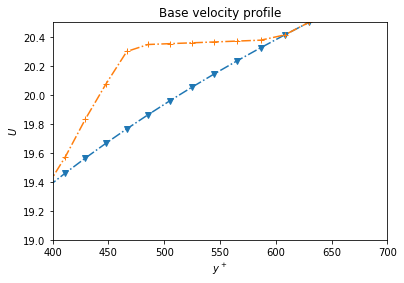

/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 2.5 6.666666666666667 10000.0
Largest growth rate for U0 is -0.0347
a, b, Re: 2.5 6.666666666666667 10000.0
Largest growth rate for U1 is 0.00438


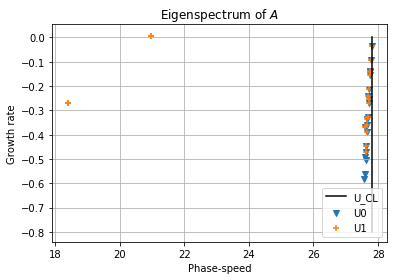

In [390]:
Uopt = Utmp(ypMin, ypMax, modAmp, posFactor=posFactor, switchLoc=optSwitchLoc)
plotBase(U0, Uopt, ypLim = [ypMin,ypMax+100.], Ulim=[19., 20.5])
plotEvals(U0, Uopt)

## Constraint 2, with posFactor as the variable

Amplitude is  5.0
Switch location to impose contraint 1 is 0.9375
Error in contraint 1 is 0.0230984401592


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 2.5 6.666666666666667 10000.0
Amplitude is  10.0
Switch location to impose contraint 1 is 0.875
Error in contraint 1 is -0.00970425757617
a, b, Re: 2.5 6.666666666666667 10000.0
Amplitude is  15.0
Switch location to impose contraint 1 is 0.875
Error in contraint 1 is -0.00970425757617
a, b, Re: 2.5 6.666666666666667 10000.0
Amplitude is  20.0
Switch location to impose contraint 1 is 0.84375
Error in contraint 1 is -0.0264746076883
a, b, Re: 2.5 6.666666666666667 10000.0
Amplitude is  25.0
Switch location to impose contraint 1 is 0.8125
Error in contraint 1 is -0.0434994024945
a, b, Re: 2.5 6.666666666666667 10000.0
Amplitude is  30.0
Switch location to impose contraint 1 is 0.78125
Error in contraint 1 is -0.0607852597506
a, b, Re: 2.5 6.666666666666667 10000.0
Amplitude is  35.0
Switch location to impose contraint 1 is 0.75
Error in contraint 1 is -0.0783390439317
a, b, Re: 2.5 6.666666666666667 10000.0
Amplitude is  40.0
Switch location to impose contraint 1 is 0.71875
Erro

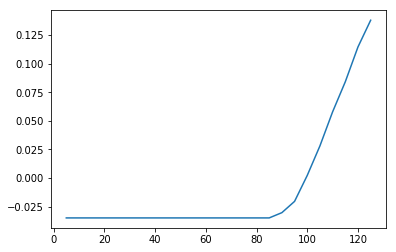

In [283]:
ypMin = 400.; ypMax = 600.; posFactor = 30. 
modAmpArr = np.arange(5., 126., 5.)
growthRateArr = np.zeros(modAmpArr.size)
for ind in range(modAmpArr.size):
    modAmp = modAmpArr[ind]
    print("Amplitude is ", modAmp)
    genFun = lambda var: Uconstr1Fun(switchLoc = var,
                                ypMin=ypMin, ypMax=ypMax, modAmp=modAmp, posFactor=posFactor)
    optSwitchLoc = miscUtil.binarySearch(genFun, 0., 1., nSteps = 20, tol = 0.01)
    print("Switch location to impose contraint 1 is", optSwitchLoc)
    print("Error in contraint 1 is", Uconstr1Fun(switchLoc=optSwitchLoc))
    growthRateArr[ind] = Uconstr2Fun(switchLoc=optSwitchLoc,
        ypMin=ypMin, ypMax=ypMax, modAmp = modAmp, posFactor=posFactor)

plt.plot(modAmpArr, growthRateArr)
plt.show()
    

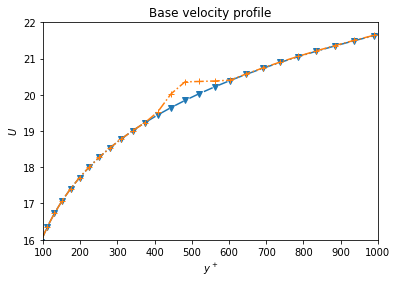

/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 2.5 6.666666666666667 10000.0
Largest growth rate for U0 is -0.0347
a, b, Re: 2.5 6.666666666666667 10000.0
Largest growth rate for U1 is -0.00702


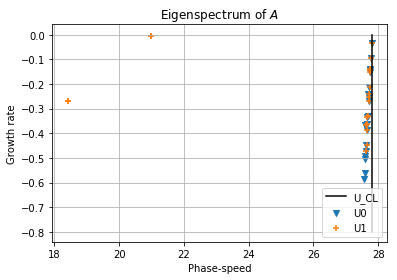

In [285]:
Uopt12 = Utmp(ypMin,ypMax, modAmp =optModAmp, posFactor=posFactor, switchLoc=optSwitchLoc)
plotBase(U0,Uopt12)
plotEvals(U0,Uopt12)

## Marginally stable modifications
### For the top-hat eddy viscosity mod, for given ypMin, ypMax, posFactor

In [424]:
pfArr = np.array([0.05, 1., 10., 25., 50., 100.])
optAmpArr = np.zeros(pfArr.size)
optLocArr = np.zeros(pfArr.size)
for ind in range(pfArr.size):
    posFactor = pfArr[ind]
    print("posFactor=",posFactor)
    optAmp, optLoc = marginalWave(ypMin=400.,ypMax=600., posFactor=posFactor, nSteps=10)
    optAmpArr[ind] = optAmp
    optLocArr[ind] = optLoc
    print("Optimal amplitude and switch location are", optAmp, optLoc)


posFactor= 0.05
tolerance 0.01 met at minVar=0. Returning...


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 2.5 6.666666666666667 10000.0


/home/svadarevu/linenv/lib/python3.5/site-packages/ipykernel/__main__.py:53: RuntimeWarning: divide by zero encountered in double_scalars


KeyboardInterrupt: 

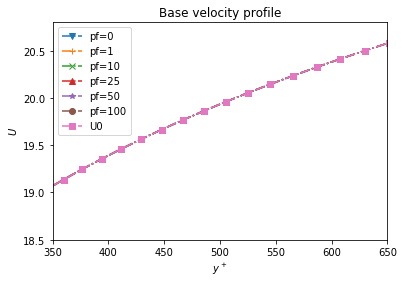

In [392]:
Ulabels = ['pf=%d'%pf for pf in pfArr]
Uprofiles=[Utmp(400.,600.,
                modAmp=optAmpArr[ind], posFactor=pfArr[ind], switchLoc=optLocArr[ind]) for ind in np.arange(pfArr.size) ]
Uprofiles.append(U0)
Ulabels.append('U0')
plotBase(*Uprofiles,Ulabels=Ulabels, ypLim=[350.,650.], Ulim=[18.5,20.8])


In [ ]:
plotEvals(*Uprofiles,Ulabels=Ulabels)

Same as before, but
### For the sinusoidal eddy viscosity mod, for given ypMin, ypMax, posFactor

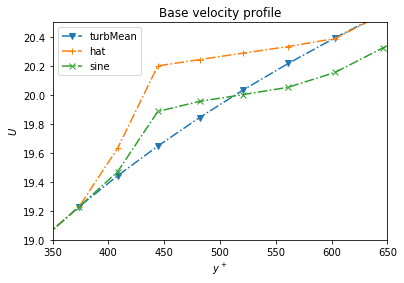

In [314]:
# First, seeing if there's any significant difference between the two:
Usine = Utmp(400., 600., posFactor= 5., switchLoc=0.15235, modAmp=127.124, sine=True)
Uhat  = Utmp(400., 600., posFactor= 5., switchLoc=0.15235, modAmp=127.124, sine=False)

plotBase(U0,Uhat,Usine,Ulabels=['turbMean','hat','sine'], ypLim=[350.,650.], Ulim=[19., 20.5])

In [336]:
pfArr = 10.**np.arange(-3, 4,1)
optAmpArr = np.zeros(pfArr.size)
optLocArr = np.zeros(pfArr.size)
for ind in range(pfArr.size):
    posFactor = pfArr[ind]
    print("posFactor=",posFactor)
    try:
        optAmp, optLoc = marginalWave(ypMin=100.,ypMax=500., ampMax=1000.,posFactor=posFactor, nSteps=13,sine=True)
    except:
        optAmp = 0.; optLoc = 0.
    optAmpArr[ind] = optAmp
    optLocArr[ind] = optLoc
    print("Optimal amplitude and switch location are", optAmp, optLoc)


posFactor= 0.001
tolerance 0.01 met at minVar=0. Returning...


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 2.5 6.666666666666667 10000.0


/home/svadarevu/linenv/lib/python3.5/site-packages/scipy/integrate/quadpack.py:356: IntegrationWarning: The integral is probably divergent, or slowly convergent.
  warnings.warn(msg, IntegrationWarning)


Optimal amplitude and switch location are 0.0 0.0
posFactor= 0.01
tolerance 0.01 met at minVar=0. Returning...
a, b, Re: 2.5 6.666666666666667 10000.0
Optimal amplitude and switch location are 0.0 0.0
posFactor= 0.1
tolerance 0.01 met at minVar=0. Returning...
a, b, Re: 2.5 6.666666666666667 10000.0
Optimal amplitude and switch location are 0.0 0.0
posFactor= 1.0
a, b, Re: 2.5 6.666666666666667 10000.0
Optimal amplitude and switch location are 0.0 0.0
posFactor= 10.0
a, b, Re: 2.5 6.666666666666667 10000.0
Optimal amplitude and switch location are 0.0 0.0
posFactor= 100.0
a, b, Re: 2.5 6.666666666666667 10000.0
Optimal amplitude and switch location are 0.0 0.0
posFactor= 1000.0
a, b, Re: 2.5 6.666666666666667 10000.0
Optimal amplitude and switch location are 0.0 0.0


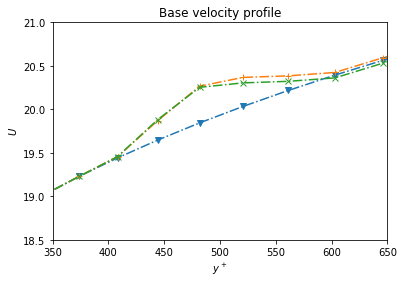

In [342]:
U1 = Utmp(400.,600.,100., switchLoc=0.47,sine=True)
U2 = Utmp(400.,600.,100., switchLoc=0.43,sine=True)
plotBase(U0,U1,U2, ypLim=[350., 650.], Ulim = [18.5,21.])

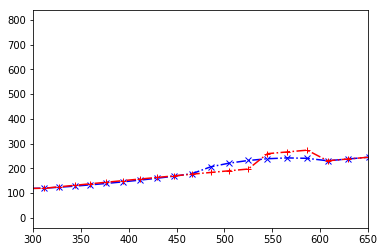

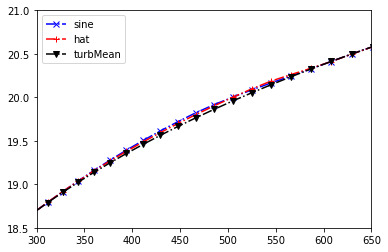

Uconstr1 for sine and hat mods is -0.000335602365478 -0.00152265752293


In [419]:
ypMin = 300.; ypMax= 600.; modAmp = 5.
ph = 10.; ps = 3.; sLocs=0.57; sLoch=0.8;
nuSine = lambda xi: nuEbase(xi) +  nuDiffSine(xi, ypMin,ypMax,2.*modAmp, posFactor= ps, switchLoc=sLocs)
nuHat  = lambda xi: nuEbase(xi)+ nuDiffHat(xi, ypMin,ypMax,modAmp, posFactor=ph, switchLoc=sLoch)

sineProfile = np.array([nuSine(yVal) for yVal in list(y)])
hatProfile = np.array([nuHat(yVal) for yVal in list(y)])

plt.plot(yp, sineProfile, 'bx-.')
plt.plot(yp, hatProfile, 'r+-.')
plt.xlim([300., 650.])
plt.show()

Us = Utmp(ypMin, ypMax, 2.*modAmp, posFactor=ps, sine=True, switchLoc=sLocs)
Uh = Utmp(ypMin, ypMax, modAmp, posFactor=ph, sine=False, switchLoc=sLoch)
plt.plot(yp, Us, 'bx-.')
plt.plot(yp, Uh, 'r+-.')
plt.plot(yp, U0, 'kv-.')
plt.xlim([300., 650.])
plt.ylim([18.5, 21.])
#plt.autoscale()
plt.legend(['sine','hat','turbMean'])
plt.show()

print("Uconstr1 for sine and hat mods is", 
     Uconstr1Fun(ypMin=ypMin, ypMax=ypMax, modAmp = 2.*modAmp, posFactor=ps, switchLoc=sLocs, sine=True),
     Uconstr1Fun(ypMin=ypMin, ypMax=ypMax, modAmp = modAmp, posFactor=ph, switchLoc=sLoch))

/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 2.5 6.666666666666667 10000.0
Largest growth rate for sine is -0.0347
a, b, Re: 2.5 6.666666666666667 10000.0
Largest growth rate for hat is -0.0347
a, b, Re: 2.5 6.666666666666667 10000.0
Largest growth rate for turb is -0.0347


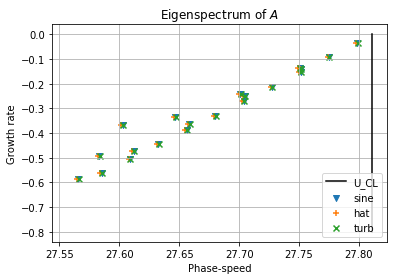

In [420]:
plotEvals(Us,Uh,U0,Ulabels=['sine','hat','turb'],Evals=40)

In [433]:
optAmp,optLoc = marginalWave(300., 600., posFactor= 10., ampMax=500., nSteps=30,sine=False)

tolerance 0.01 met at minVar=0. Returning...


/home/svadarevu/gitwork/linear/library/ops.py:191: UserWarning: To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS
  warn("To use eddy viscosity, pass kwarg 'nu'=self.nu to either makeSystem/makeAdjSystem, dynamicsMat, or OSS")
/home/svadarevu/gitwork/linear/library/ops.py:227: UserWarning: dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.
  warn("dnu and d2nu are currently set to zero. Revisit this to implement eddy viscosity.")


a, b, Re: 2.5 6.666666666666667 10000.0


AssertionError: 

# Verifying weight matrices

I'll use $(u,v,w) = (1-y^{10}, 1-y^{10}, 1-y^{10})$ and see if the weight matrices give the right energy.

$$ 0.5 \int\limits_{y=-1}^{1} (|u|^2 + |v|^2 + |w|^2 )dy  $$
$$=1.5 \int\limits_{y=-1}^{1} (1+y^{20} - 2y^{10}) dy$$
$$= 1.5\bigg[ y + y^{21}/21 - 2y^{11}/11 \bigg]_{-1}^{1} = (3/2)(2+2/21-4/11) =  2.5974$$

In [87]:
N = 12
weightDict = pseudo.weightMats(N)
W3s = weightDict['W3Sqrt']
W3si = weightDict['W3SqrtInv']
y = pseudo.chebdif(N,1)[0]
u3 = np.concatenate((1.-y**10, 1.-y**10, 1.-y**10))
u3w = W3s @ u3

print("Norm of the 1-y^2 field is",u3w @ u3w, )
print("Norm of difference:", pseudo.chebnorm(u3 - W3si@u3w,N) )

Norm of the 1-y^2 field is 2.59738210347
Norm of difference: 8.57806066843e-17


Looks alright. 